<a href="https://colab.research.google.com/github/kin0969/ML-Homework/blob/master/Twitter_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###General Path Config

In [21]:
# Mount Google Drive for read and write
from google.colab import drive
drive.mount('/content/gdrive')
training_label="/content/gdrive/My Drive/Colab Notebooks/ML Homework/RNN 2020/Raw Data/"+"training_label.txt"
training_nolabel="/content/gdrive/My Drive/Colab Notebooks/ML Homework/RNN 2020/Raw Data/"+"training_nolabel.txt"
testing_data="/content/gdrive/My Drive/Colab Notebooks/ML Homework/RNN 2020/Raw Data/"+"testing_data.txt"
w2v_model='w2v_hw_label_text.model'  
W2v_dimension=250

predict="/content/gdrive/My Drive/Colab Notebooks/ML Homework/RNN 2020/Result/"+"predict.csv"
general_result_path="/content/gdrive/My Drive/Colab Notebooks/ML Homework/RNN 2020/Result/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###Utils

In [0]:
# Utils.py
# General library
 
 import torch
 import numpy as np
 import pandas as pd
 import torch.optim as optim
 import torch.nn.functional as F

 def load_training_data(path,with_label):   
   # 把 training 時需要的 data 讀進來
   # 如果是 'training_label.txt'，需要讀取 label，如果是 'training_nolabel.txt'，不需要讀取 label
   if with_label=='Y':
     with open(path,'r') as f:
       lines=f.readlines()       
       lines=[line.strip('\n').split(' ') for line in lines]
     
     x= [line[2:] for line in lines]
     y= [line[0] for line in lines] 
     return x,y
   else:
     with open(path, 'r') as f:
            lines = f.readlines()
            x = [line.strip('\n').split(' ') for line in lines]
     return x


def load_testing_data(path):
    # 把 testing 時需要的 data 讀進來
    with open(path, 'r') as f:
        lines = f.readlines()
        
        # 先不要header, 再去分行符號，再用逗號分隔
        lines_staging=[line.strip('\n').split(",") for line in lines[1:]]
        # 再把整句Raw句子拿出來 
        lines_staging= [line[1:] for line in lines_staging]
        # 再使用句子中的空格split出得出每個字，line係object冇split, 所以加D野上去變成String
        lines_staging= ["".join(line).split(' ') for line in lines_staging]    

    return lines_staging

def acc_evaluation(outputs, labels):
  outputs[outputs>=0.5]=1
  outputs[outputs<0.5]=0
  correct=torch.sum(torch.eq(outputs,labels)).item()
  return correct
  




### Train Word to Vector

In [0]:
# 這個 block 是用來訓練 word to vector 的 word embedding
# 注意！這個 block 在訓練 word to vector 時是用 cpu，可能要花到 10 分鐘以上
# 只是把所有字轉化成Vector, 並寫進model

import os
import numpy as np
import pandas as pd
import argparse
from gensim.models import word2vec

def train_word2vec(x):
  model=word2vec.Word2Vec(x,size=W2v_dimension,window=5,min_count=5,workers=12,iter=10,sg=1)
  return model


if __name__!="__main__":
  print ("Loading training data for training word2vec")
  train_x,y=load_training_data(training_label,'Y')
  train_x_no_label=load_training_data(training_nolabel,'N')

  print("Loading testing data for training word2vec")
  test_x=load_testing_data(testing_data)

  model =train_word2vec(train_x + test_x)

  print ("Saving models")
  model.save(general_result_path+w2v_model)

###Building an usable dictionary mapping

In [0]:
# 繼續上個Block的工作，使用已build好的embedding 製偏 1個可用作文字learning 既機制
# 以下3個製作成品皆包含 model 全部的words
# 製作一個 word2idx 的 dictionary -> self.word2index['he'] = 1
# 製作一個 idx2word 的 list       -> self.index2word[1] = 'he'
# 製作一個 word2vector 的 list    -> self.embedding_matrix[1]='he' Vector= [1,2,5,7,8.....]


from torch import nn
from gensim.models import Word2Vec

class Dict_mapping():
  # __init__ is contractor, self是指明使用class的object
  def __init__(self,sentences,sen_len,w2v_path=general_result_path+w2v_model):
    self.w2v_path=w2v_path
    self.sentences=sentences   # 所有句子，所有text
    self.sen_len=sen_len       # 統一設定每一句子的長度

    self.word2idx_dict={}
    self.idx2word=[]
    self.embedding_matrix=[]

  def get_w2v_model(self):
    # 把之前訓練好的 word to vec 模型讀進來
    self.embedding=Word2Vec.load(self.w2v_path)
    self.embedding_dim=self.embedding.vector_size


  def add_embedding(self,word):
    #此設計只補上2種word， 就是 "<PAD>" 或 "<UNK>"
    #<PAD> for 句子不夠長，補字員以統一長度；<UNK> for 未見過既字
    #2個新字都隨機生成embedding vector, 再加至embedding_matrix中
    vector=torch.empty(1,self.embedding_dim)
    torch.nn.init.uniform_(vector)   # uniform->很平均的分佈?
    self.word2idx_dict[word]=len(self.word2idx_dict)
    self.idx2word.append(word)       #1 維可以append
    self.embedding_matrix=torch.cat([self.embedding_matrix,vector],0)    #Torch就要concat了
    
  def make_dict_embedding(self,load=True):
    #真正建構3款dict同vector
    print("Get pre-train embedding ...")
    if load:
      self.get_w2v_model()
    else:
      raise NotImplementedError
   
    #把gensim model中的每個字都拿出來
    for i,word in enumerate (self.embedding.wv.vocab):      
      print ('get words#{}:{}'.format(i+1,word),end='\r')      
      self.word2idx_dict[word] = len(self.word2idx_dict)
      self.idx2word.append(word)
      self.embedding_matrix.append(self.embedding[word])

    print('')
    self.embedding_matrix = torch.tensor(self.embedding_matrix)
    # 將 "<PAD>" 跟 "<UNK>" 加進 embedding 裡面
    self.add_embedding("<PAD>")
    self.add_embedding("<UNK>")
    print ("Total words in embedding matrix: {}".format(len(self.embedding_matrix)))
    return self.embedding_matrix

   
  def adjust_sentence_length(self,sentence):     
    # 此時的sentence已是index
    # 太長的地方縮短
    if len(sentence)>self.sen_len:
      sentence=sentence[:self.sen_len]
    else:
    # 統一pad 每一句子的字數, 不足的地方, 加"<PAD>"     
      pad_len=self.sen_len-len(sentence)
      for _ in range(pad_len):
        sentence.append(self.word2idx_dict["<PAD>"])
    
    # 若以下條件不成立就馬上報錯
    assert len(sentence)==self.sen_len
    return sentence

   
  def sentences_word2idx(self):     
    # 把所有句子中的字變成index
    # 把input x變成 LongTensor, 準備作learning
    sentence_idx_list=[]
    for i,sen in enumerate(self.sentences):
      sentence_idx=[]
      
      for word in sen:
        if (word in self.word2idx_dict.keys()):
          sentence_idx.append(self.word2idx_dict[word])
        else :
          sentence_idx.append(self.word2idx_dict["<UNK>"])

      # 使長度一致
      sentence_idx=self.adjust_sentence_length(sentence_idx)
      sentence_idx_list.append(sentence_idx)
    return torch.LongTensor(sentence_idx_list)
    

   
  def labels_to_tensor(self,y):  
    # 把 labels y 轉成 tensor
    # 因在本身 Python的list 值都是文字，所以需先轉成數字
    y = [int(label) for label in y]     
    return torch.LongTensor(y)    
         


###Dataset

In [0]:
# pytorch 的 Dataset class
# init 後 data 就會自己分成batch, 就可以用for讀曬佢
#一定要實作此3個class, 才能使用dataloader
import torch
from torch.utils import data

class TwitterDataset(data.Dataset):
  def __init__(self, X,y):
    self.data=X
    self.label=y

  def __getitem__(self, idx):
    if self.label is None: return self.data[idx]
    return self.data[idx],self.label[idx]

  def __len__(self):
    return len(self.data)



###Model

In [0]:
# nn.Module 是 Base class for all neural network modules
import torch
from torch import nn

#新Class 先繼承 nn.Module
class LSTM_Net(nn.Module):
  # num_layers=  Deep or not Deep? 多於1層就是deep了。就是重覆的架構多疊幾個LSTM的cell?
  # hidden_dim= 神經網路每一層的神經元數目，也是輸出的特徵數目。
  def __init__(self,embedding_matrix,embedding_dim,hidden_dim,num_layers,dropout=0.5,fix_embedding=True ):
    # Super 即是指使用父類的funciton,在此即initial nn.Module
    # 另一種寫法為，super().__init__()
    super(LSTM_Net,self).__init__()
    # nn 有提供embedding 層的設計，下2行是把Gensim學到的embedding_matrix導入至LSTM
    self.LSTM_embedding_matrix=torch.nn.Embedding(embedding_matrix.size(0),embedding_matrix.size(1))
    self.LSTM_embedding_matrix.weight=torch.nn.Parameter(embedding_matrix)
    # 是否將 LSTM_embedding fix 住，若沒有fix住，在訓練過程中，embedding 也會跟著被訓練
    # requires_grad就是求導的產物，沒有gradient，就不會改動
    self.LSTM_embedding_matrix.weight.requires_grad=False if fix_embedding else True
    self.LSTM_embedding_dim=embedding_matrix.size(1)
    self.LSTM_hidden_dim=hidden_dim
    self.LSTM_num_layers=num_layers
    self.LSTM_dropout=dropout
    # batch_first= True,  即input及output data 打橫擺， shape (batch_size, seq_len, features)
    # batch_first= False, 即input及output data 打直擺， shape (seq_len, batch_size, features)
       
    self.LSTM=nn.LSTM(self.LSTM_embedding_dim,self.LSTM_hidden_dim,num_layers=self.LSTM_num_layers,batch_first=True)
    self.classifier=nn.Sequential(
        nn.Dropout(self.LSTM_dropout),
        nn.Linear(self.LSTM_hidden_dim,1),
        nn.Sigmoid()

        # nn.Dropout(self.LSTM_dropout),
        # nn.Linear(self.LSTM_hidden_dim,self.LSTM_hidden_dim),
        # nn.Tanh(),
        # nn.Linear(self.LSTM_hidden_dim,1),
        # nn.Sigmoid()
    )



  # 定義forward function, backward function會自己找
  def forward(self, inputs ):
    # 把input的words 轉回 Gensim vectors format
    inputs=self.LSTM_embedding_matrix(inputs)
    # None 指 nn.LSTM 中， h_0 of shape-> 設定bidirectional， c_0 of shape -> Cell預設值    
    x,_=self.LSTM(inputs,None)
    # 因Batch_First= True, 所以LSTM最後一層為x[:, -1, :] ，否則為x[-1,:, :]
    # 也有另一個說法是最後一層為所有data的壓縮精華，所以跟features數目無關，應該與data數量有關
    x=x[:, -1, :]
    x=self.classifier(x)
    return x

###Train

In [0]:
import torch
from torch import nn
import torch.optim  as optim
import matplotlib.pyplot as plt

# model = LSTM_Net(embedding, embedding_dim=250, hidden_dim=150, num_layers=1, dropout=0.5, fix_embedding=fix_embedding)
# model = model.to(device) # device為 "cuda"，model 使用 GPU 來訓練（餵進去的 inputs 也需要是 cuda tensor）

def training(brach_size,n_epoch,lr,model_dir,train,valid, model,device):
  # 列出所有參數
  total=sum(p.numel() for p in model.parameters())
  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print('\n Start Training,parameter total:{}, trainable:{}\n'.format(total,trainable))
  model.train() # 將 model 的模式設為 train，這樣 dropout 和 batchNorm 便可使用   
  criterion=nn.BCELoss() # 定義損失函數，這裡我們使用 binary cross entropy loss
  t_dataloader_batch=len(train)
  v_dataloader_batch=len(valid)
  optimizer=optim.Adam(model.parameters(), lr=lr) # 將模型的參數給 optimizer，並給予適當的 learning rate
  total_loss,total_acc,best_acc=0,0,0
  plt_train_loss=[]
  plt_train_acc=[]
  plt_valid_loss=[]
  plt_valid_acc=[]

  for epoch in range(n_epoch):
    model.train()
    total_loss,total_acc=0,0
    
    # 以下做 Training
    for i,(inputs,labels) in enumerate(train):
      inputs=inputs.to(device,dtype=torch.long)  #轉用Cuda,以便使用GPU
      # labels=labels.to(device,dytpe=torch.float32) #將 labels 轉成 FloatTensor，因為等等要餵進 criterion，計 entropy lost, 所以型態要是 float
      labels = labels.to(device, dtype=torch.float)
        
      # labels=labels.cuda()
      # labels=labels.float()
      optimizer.zero_grad()  # 由於 loss.backward() 的 gradient 會累加，所以每次餵完一個 batch 後需要歸零
      outputs=model(inputs) # 將 input 餵給模型
      outputs=outputs.squeeze() # 去掉所有維度為1的dimension，即由[1,3]->[3],使計算Loss的 lable Tensor更一致
      loss=criterion(outputs,labels)
      loss.backward() # 算 loss 的 gradient
      optimizer.step() # 更新訓練模型的參數
      acc=acc_evaluation(outputs,labels)
      total_acc+=(acc/batch_size)
      total_loss=+loss.item() # nn.BCELoss()直接輸出此round此dataloader的此batch平均 loss       
      print('[ Epoch{}: {}/{} ] loss:{:.3f} acc:{:.3f} '.format(
            	epoch+1, i+1, t_dataloader_batch, loss.item(), acc*100/batch_size), end='\r')    
    plt_train_loss.append(total_loss/t_dataloader_batch) # 記録每個epoch的資料以後畫圖使用
    plt_train_acc.append(total_acc/t_dataloader_batch*100)
    print('Train | Loss:{:.5f} Acc: {:.3f}'.format(total_loss/t_dataloader_batch, total_acc/t_dataloader_batch*100)) # 此epoch Training 已完


    # 以下做 Validation
    model.eval() # 將 model 的模式設為 eval，這樣 便不dropout 和 batchNorm
    with torch.no_grad(): #把此 block的所有參數暫時set做  requires_grad flag to false， 速度會加快很多    
      total_loss, total_acc = 0, 0
      for i,(inputs,labels) in enumerate(valid):
        inputs = inputs.to(device, dtype=torch.long) 
        labels = labels.to(device, dtype=torch.float)
        outputs=model(inputs)
        outputs=outputs.squeeze()
        loss=criterion(outputs, labels)
        acc=acc_evaluation(outputs,labels)
        total_acc+=(acc/batch_size)
        total_loss=+loss.item()
      
      plt_valid_loss.append(total_loss/v_dataloader_batch)
      plt_valid_acc.append(total_acc/v_dataloader_batch*100)
      print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_dataloader_batch, total_acc/v_dataloader_batch*100))

      if total_acc>best_acc:
        # 如果 validation 的結果優於之前所有的結果，就把當下的模型存下來以備之後做預測時使用                
        best_acc=total_acc
        torch.save(model,"{}/ckpt.model".format(model_dir))
        print("Saving model with Valid Acc {:.3f}".format(total_acc/v_dataloader_batch*100))
    print('-----------------------------------------------')

  plt.plot(plt_train_loss)
  plt.plot(plt_valid_loss)
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'Valid'], loc='upper left')
  plt.show()

  plt.plot(plt_train_acc)
  plt.plot(plt_valid_acc)
  plt.title('Model Acc')
  plt.ylabel('Acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'Valid'], loc='upper left')
  plt.show()


### Predict

In [0]:
# 做預測
import torch
from torch import nn
import torch.optim as optim

def Predict(batch_size,test_loader,model,device):
  model.eval()
  ret_output=[]
  with torch.no_grad():
    for i, inputs in enumerate (test_loader):
      inputs = inputs.to(device, dtype=torch.long)
      outputs=model(inputs)
      outputs=outputs.squeeze()
      outputs[outputs>=0.5] = 1 # 大於等於 0.5 為正面
      outputs[outputs<0.5] = 0 # 小於 0.5 為負面
      ret_output+=outputs.int().tolist()
  return ret_output





###Main


 Loading Data for model training 

Get pre-train embedding ...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


get words#1238:shit

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


get words#24694:ˆâ
Total words in embedding matrix: 24696

 train_x torch.Size([200000, 20])
 

 Start Training,parameter total:6415351, trainable:241351

Train | Loss:0.00047 Acc: 73.689
Valid | Loss:0.00487 Acc: 78.165 
Saving model with Valid Acc 78.165
-----------------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LSTM_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train | Loss:0.00044 Acc: 78.857
Valid | Loss:0.00451 Acc: 79.335 
Saving model with Valid Acc 79.335
-----------------------------------------------
Train | Loss:0.00048 Acc: 79.876
Valid | Loss:0.00436 Acc: 79.975 
Saving model with Valid Acc 79.975
-----------------------------------------------
Train | Loss:0.00052 Acc: 80.587
Valid | Loss:0.00415 Acc: 80.185 
Saving model with Valid Acc 80.185
-----------------------------------------------
Train | Loss:0.00046 Acc: 81.267
Valid | Loss:0.00405 Acc: 80.445 
Saving model with Valid Acc 80.445
-----------------------------------------------
Train | Loss:0.00038 Acc: 81.814
Valid | Loss:0.00392 Acc: 80.195 
-----------------------------------------------
Train | Loss:0.00048 Acc: 82.425
Valid | Loss:0.00386 Acc: 80.565 
Saving model with Valid Acc 80.565
-----------------------------------------------
Train | Loss:0.00041 Acc: 83.032
Valid | Loss:0.00367 Acc: 80.630 
Saving model with Valid Acc 80.630
---------------------------------

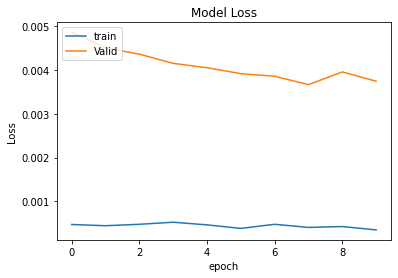

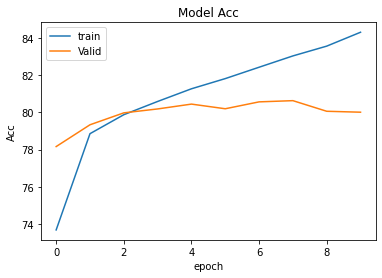

In [29]:
import os
import torch
from torch import nn

# 通過 torch.cuda.is_available() 的回傳值進行判斷是否有使用 GPU 的環境，如果有的話 device 就設為 "cuda"，沒有的話就設為 "cpu"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 總參數設定
sen_len=20
fix_embedding_Flag=True # fix embedding during training
batch_size=200  #留意Dataloader有drop_last參數，預設為false,即不能整除時則最後batch會較少，所以建議設定成可整除 Train 及 Valid的資金料量
epoch=10
lr=0.001
LSTM_hidden_dim=150
dropout=0.5




print ("\n Loading Data for model training \n")
train_x,y=load_training_data(training_label,'Y')
train_x_no_label=load_training_data(training_nolabel,'N')

# 製作 embedding 及 training data map進去
dict_mapping=Dict_mapping(train_x, sen_len, general_result_path+w2v_model)
embedding_matrix = dict_mapping.make_dict_embedding(load=True)  # Build dictonary word embedding
train_x = dict_mapping.sentences_word2idx()  #把train 的sentence map 入 embedding
y = dict_mapping.labels_to_tensor(y)

print ("\n train_x {}\n ".format(train_x.shape) )

# Initial model
model=LSTM_Net(embedding_matrix,embedding_dim=W2v_dimension,hidden_dim=LSTM_hidden_dim,num_layers=1,dropout=dropout,fix_embedding=fix_embedding_Flag)
model= model.to(device)  # device 為"cuda"的話，model 會使用GPU，但餵進去的 inputs 也需要是 cuda tensor
# train_x.cuda()
# y.cuda()

# 把 data 分為 training data 跟 validation data
# 雖然 train_x 的size 係([200000, 20])，但取資料時如果全取可省略直行index
X_train, X_val, y_train, y_val = train_x[:180000], train_x[180000:], y[:180000], y[180000:]

# 把 data 做成 dataset 供 dataloader 取用
train_dataset = TwitterDataset(X=X_train, y=y_train)
val_dataset = TwitterDataset(X=X_val, y=y_val)

# 把 data 轉成 batch of tensors
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

# 開始訓練
training(batch_size, epoch, lr, general_result_path, train_loader, val_loader, model, device)




###Predict and Write to csv file

In [32]:
#開始做Predict
import pandas as pd
print("Loading testing data ...")
test_x=load_testing_data(testing_data)

dict_mapping=Dict_mapping(test_x, sen_len, general_result_path+w2v_model)
embedding_matrix = dict_mapping.make_dict_embedding(load=True)  # Build dictonary word embedding
test_x = dict_mapping.sentences_word2idx()  #把sentence map 入 embedding

test_dataset = TwitterDataset(X=test_x, y=None)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                            batch_size = batch_size,
                                            shuffle = False,
                                            num_workers = 8)

print("\nLoading model...")
model=torch.load("{}/ckpt.model".format(general_result_path))
outputs=Predict(batch_size,test_loader,model,device)

# 寫到 csv 檔案供上傳 Kaggle
tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"label":outputs})
print("Saving csv ...")
tmp.to_csv(predict, index=False)
print("Finish Predicting")




Loading testing data ...
Get pre-train embedding ...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


get words#24694:ˆâ
Total words in embedding matrix: 24696

Loading model...
Saving csv ...
Finish Predicting


In [0]:
# a = []
# while(1):
#   a.append('1')

# from google.colab import files
#!df -h

import torch
a=torch.randn(1,3)
print (a)
print (a.shape)


b=a.squeeze()
print (b)
print ('b shape {}'.format(b.shape))